# Master Data Science, Lyon 1
# TP1 PGM (durée 2h) 

Alex Aussem (aaussem@univ-lyon1.fr)

***
In this tutrial, you will learn how to create and train PGM models with **aGrUM/PyAGrUM**, a GRaphical Universal Modeler available at https://agrum.gitlab.io, developed at LIP6 - DESIR department - Decision Theory team, Université Sorbonne, by Pierre-Henri Wuillemin, Christophe Gonzales and many contributors (PhD students).

The main concepts (conditional independencies, parameter learning, inference, structure learning etc.) seen in the PGM course (Master Data Science, Lyon 1) will be illustrated as well as the excerices.

See also: https://gitlab.com/agrumery/aGrUM,

Installation: conda install -c conda-forge pyagrum

**aGrUM** is a C++ library for graphical models. It is designed for easily building applications using graphical models such as Bayesian networks, influence diagrams, decision trees, GAI networks or Markov decision processes. 

**PyAGrUM** is a Python wrapper for the C++ aGrUM library. It provides a high-level interface to the part of aGrUM allowing to create, handle and make computations into Bayesian Networks.

In this notebook, you will learn how to 

- design a BN model with the basic building blocks provided by Agrum/pyAgrum,
- learn its structure and the parameters from data 
- perform exact or approximate inference with evidence, 
- play with several benchmlark models like **ASIA** and **ALARM**.

Template BNs in various formats are available at: 
https://github.com/eBay/bayesian-belief-networks/tree/master/bayesian/examples/bif

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [3]:
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.6.4 (v3.6.4:d48eceb, Dec 19 2017, 06:04:45) [MSC v.1900 32 bit (Intel)]"
IPython,7.0.1
MatPlotLib,3.0.2
Numpy,1.14.2
pyAgrum,0.13.6


## Create the network topology


In [3]:
bn=gum.BayesNet('WaterSprinkler')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, parameters: 0, compression ratio: 100-10^-inf% }


In [4]:
c=bn.add(gum.LabelizedVariable('c','cloudy ?',2))
print(c)

0


In [5]:
s, r, w = [ bn.add(name, 2) for name in "srw" ] #bn.add(name, 2) === bn.add(gum.LabelizedVariable(name, name, 2))
print (s,r,w)
print (bn)

1 2 3
BN{nodes: 4, arcs: 0, domainSize: 16, parameters: 8, compression ratio: 50% }


In [6]:
bn.addArc(c,s)

In [7]:
for link in [(c,r),(s,w),(r,w)]:
    bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, parameters: 18, compression ratio: -12% }


In [8]:
#import pyAgrum.lib.notebook as gnb
bn

(gum::BayesNet<double>@0000025DFEEE78A0) BN{nodes: 4, arcs: 4, domainSize: 16, parameters: 18, compression ratio: -12% }

In [9]:
bn.cpt(c).fillWith([0.5,0.5])

(gum::Potential<double>@0000025DFB0B1530) <c:0> :: 0.5 /<c:1> :: 0.5

In [10]:
bn.cpt("c").fillWith([0.4,0.6])

(gum::Potential<double>@0000025DFB0B1530) <c:0> :: 0.4 /<c:1> :: 0.6

In [11]:
bn.cpt(s).var_names

['c', 's']

In [12]:
bn.cpt(s)[:]=[ [0.5,0.5],[0.9,0.1]]

In [13]:
print(bn.cpt(s)[1])

[0.9 0.1]


In [14]:
bn.cpt(s)

(gum::Potential<double>@0000025DFB0B1950) <s:0|c:0> :: 0.5 /<s:1|c:0> :: 0.5 /<s:0|c:1> :: 0.9 /<s:1|c:1> :: 0.1

In [15]:
bn.cpt(w)[0,0,:] = [1, 0] # r=0,s=0
bn.cpt(w)[0,1,:] = [0.1, 0.9] # r=0,s=1
bn.cpt(w)[1,0,:] = [0.1, 0.9] # r=1,s=0
bn.cpt(w)[1,1,:] = [0.01, 0.99] # r=1,s=1
bn.cpt(w)

(gum::Potential<double>@0000025DFB0B1670) <w:0|s:0|r:0> :: 1 /<w:1|s:0|r:0> :: 0 /<w:0|s:1|r:0> :: 0.1 /<w:1|s:1|r:0> :: 0.9 /<w:0|s:0|r:1> :: 0.1 /<w:1|s:0|r:1> :: 0.9 /<w:0|s:1|r:1> :: 0.01 /<w:1|s:1|r:1> :: 0.99

In [16]:
bn.cpt(r)[{'c':0}]=[0.8,0.2]
bn.cpt(r)[{'c':1}]=[0.2,0.8]
bn.cpt(r)

(gum::Potential<double>@0000025DFB0B1C10) <r:0|c:0> :: 0.8 /<r:1|c:0> :: 0.2 /<r:0|c:1> :: 0.2 /<r:1|c:1> :: 0.8

## Inference with evidence

In [17]:
gnb.sideBySide(bn.cpt(c),bn.cpt(r),bn.cpt(s),bn.cpt(w))

In [17]:
ie=gum.LazyPropagation(bn)
ie.makeInference()

In [18]:
print (ie.posterior(w))

<w:0> :: 0.33328 /<w:1> :: 0.66672


In [18]:
pT = bn.cpt(c)*bn.cpt(r)*bn.cpt(s)*bn.cpt(w)
pW = pT.margSumOut(['c', 's', 'r'])
pW

(gum::Potential<double>@0000025DFB0B1B90) <w:0> :: 0.33328 /<w:1> :: 0.66672

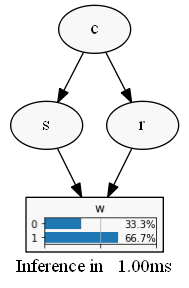

In [19]:
gnb.showInference(bn,targets={'w'})

##### =========================================

In [21]:
pWgivenSR = (pT.margSumOut(['c']))/(pT.margSumOut(['w', 'c']))
pWgivenSR[0,0,0]

1.0

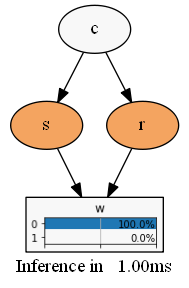

In [22]:
gnb.showInference(bn,evs={'s':0, 'r':0},targets={'w'})

In [24]:
ie=gum.LazyPropagation(bn)
ie.setEvidence({'s':0, 'r':0})
ie.makeInference()
ie.posterior(w)

(gum::Potential<double>@0000025DFF0B4080) <w:0> :: 1 /<w:1> :: 0

##### =========================================

In [26]:
pWR = pT.margSumOut(['c', 's'])
pWR[0,0]

0.2852

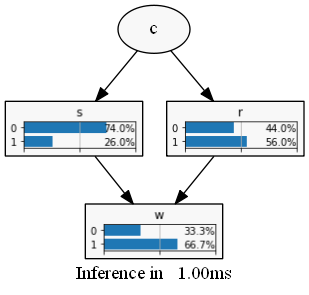

In [32]:
gnb.showInference(bn,targets={'w', 'r','s'})

In [29]:
ie=gum.LazyPropagation(bn)
ie.addJointTarget([c,s,r,w])
ie.jointPosterior([w,r])

(gum::Potential<double>@0000025DFF0487E0) <r:0|w:0> :: 0.2852 /<r:1|w:0> :: 0.04808 /<r:0|w:1> :: 0.1548 /<r:1|w:1> :: 0.51192

##### =========================================

In [19]:
ie.posterior(w)

(gum::Potential<double>@02E506B8) <w:0> :: 0.33328 /<w:1> :: 0.66672

In [20]:
ie.setEvidence({'s':0, 'c': 0})
ie.makeInference()
ie.posterior(w)

(gum::Potential<double>@02E50868) <w:0> :: 0.82 /<w:1> :: 0.18

In [21]:
ie.setEvidence({'s': [0.5, 1], 'c': [1, 0]})
ie.makeInference()
ie.posterior(w) # using gnb's feature

(gum::Potential<double>@02E50820) <w:0> :: 0.328 /<w:1> :: 0.672

In [22]:
ie.setEvidence({'s': [0.5, 1]})
ie.makeInference()
ie.posterior(w) # using gnb's feature

(gum::Potential<double>@02E506D0) <w:0> :: 0.278857 /<w:1> :: 0.721143

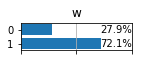

In [23]:
%matplotlib inline
gnb.showProba(ie.posterior(w))

In [24]:
ie.setEvidence({'s': [1, 0], 'c': [0, 1]})
ie.makeInference()
ie.posterior(w) # using gnb's feature

(gum::Potential<double>@02E50E68) <w:0> :: 0.28 /<w:1> :: 0.72

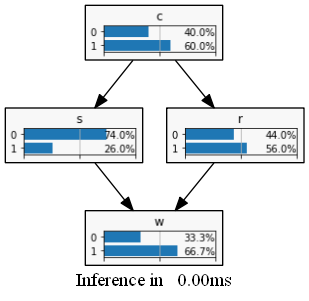

In [25]:
gnb.showInference(bn,evs={})

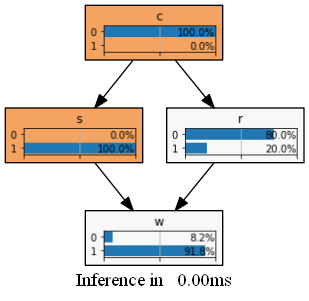

In [26]:
gnb.showInference(bn,evs={'s':1,'c':0})

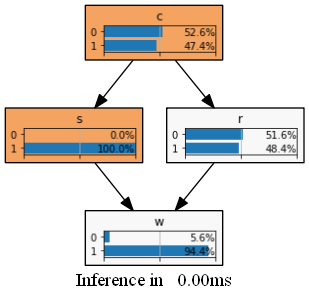

In [27]:
gnb.showInference(bn,evs={'s':1,'c':[0.3,0.9]})

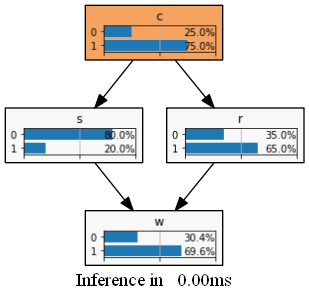

In [28]:
gnb.showInference(bn,evs={'c':[0.5,1]})
# 0.4 x 0.5 = 0.2 , 0.6 x 1 = 0.6 , 0.2 / (0.2 + 0.6) = 25.0%

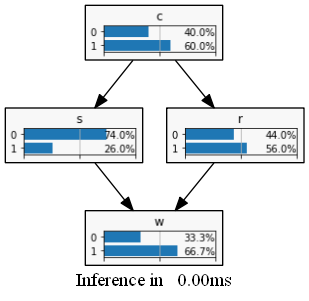

In [29]:
gnb.showInference(bn)

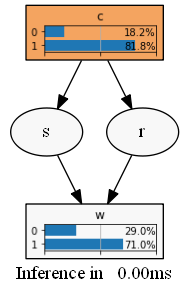

In [30]:
gnb.showInference(bn,evs={'c':[0.3,0.9]},targets={'c','w'})

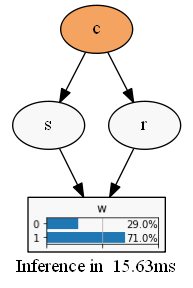

In [31]:
gnb.showInference(bn,evs={'c':[0.3,0.9]},targets={'w'})

# Joint probablity distribution

In [32]:
pCRSW=bn.cpt("c")*bn.cpt("r")*bn.cpt("s")*bn.cpt("w")
pCRSW

(gum::Potential<double>@060988A8) <s:0|r:0|w:0|c:0> :: 0.16 /<s:1|r:0|w:0|c:0> :: 0.016 /<s:0|r:1|w:0|c:0> :: 0.004 /<s:1|r:1|w:0|c:0> :: 0.0004 /<s:0|r:0|w:1|c:0> :: 0 /<s:1|r:0|w:1|c:0> :: 0.144 /<s:0|r:1|w:1|c:0> :: 0.036 /<s:1|r:1|w:1|c:0> :: 0.0396 /<s:0|r:0|w:0|c:1> :: 0.108 /<s:1|r:0|w:0|c:1> :: 0.0012 /<s:0|r:1|w:0|c:1> :: 0.0432 /<s:1|r:1|w:0|c:1> :: 0.00048 /<s:0|r:0|w:1|c:1> :: 0 /<s:1|r:0|w:1|c:1> :: 0.0108 /<s:0|r:1|w:1|c:1> :: 0.3888 /<s:1|r:1|w:1|c:1> :: 0.04752

In [33]:
pWgivenC=(pCRSW.margSumOut(["r","s"])/pCRSW.margSumOut(["r","s","w"]))
pWgivenC

(gum::Potential<double>@06098AD0) <c:0|w:0> :: 0.451 /<c:1|w:0> :: 0.2548 /<c:0|w:1> :: 0.549 /<c:1|w:1> :: 0.7452

In [34]:
pRS=pCRSW.margSumOut(["c","w"])
pRS

(gum::Potential<double>@06098B30) <s:0|r:0> :: 0.268 /<s:1|r:0> :: 0.172 /<s:0|r:1> :: 0.472 /<s:1|r:1> :: 0.088

In [35]:
pRS.margSumOut(["r"])

(gum::Potential<double>@06098CB0) <s:0> :: 0.74 /<s:1> :: 0.26

## Loading a benchmark BN model

In [36]:
!pwd
bn = gum.loadBN(os.path.join("templates","alarm.bif"))
#bn = gum.loadBN("alarm.bif")

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
gnb.showBN(bn,size='10')

# Visualisation and inspection


In [38]:
print(bn.variableFromName('SHUNT'))

SHUNT<NORMAL,HIGH>


In [39]:
print(bn.cpt(bn.idFromName('SHUNT')))

<SHUNT:NORMAL|INTUBATION:NORMAL|PULMEMBOLUS:TRUE> :: 0.1 /<SHUNT:HIGH|INTUBATION:NORMAL|PULMEMBOLUS:TRUE> :: 0.9 /<SHUNT:NORMAL|INTUBATION:ESOPHAGEAL|PULMEMBOLUS:TRUE> :: 0.1 /<SHUNT:HIGH|INTUBATION:ESOPHAGEAL|PULMEMBOLUS:TRUE> :: 0.9 /<SHUNT:NORMAL|INTUBATION:ONESIDED|PULMEMBOLUS:TRUE> :: 0.01 /<SHUNT:HIGH|INTUBATION:ONESIDED|PULMEMBOLUS:TRUE> :: 0.99 /<SHUNT:NORMAL|INTUBATION:NORMAL|PULMEMBOLUS:FALSE> :: 0.95 /<SHUNT:HIGH|INTUBATION:NORMAL|PULMEMBOLUS:FALSE> :: 0.05 /<SHUNT:NORMAL|INTUBATION:ESOPHAGEAL|PULMEMBOLUS:FALSE> :: 0.95 /<SHUNT:HIGH|INTUBATION:ESOPHAGEAL|PULMEMBOLUS:FALSE> :: 0.05 /<SHUNT:NORMAL|INTUBATION:ONESIDED|PULMEMBOLUS:FALSE> :: 0.05 /<SHUNT:HIGH|INTUBATION:ONESIDED|PULMEMBOLUS:FALSE> :: 0.95


In [40]:
gnb.showPotential(bn.cpt(bn.idFromName('SHUNT')),digits=3)

# Inference

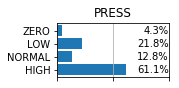

In [41]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
gnb.showPosterior(bn,{'SHUNT':'HIGH'},'PRESS')

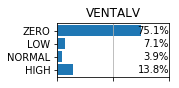

In [42]:
gnb.showPosterior(bn,{'MINVOLSET':'NORMAL'},'VENTALV')

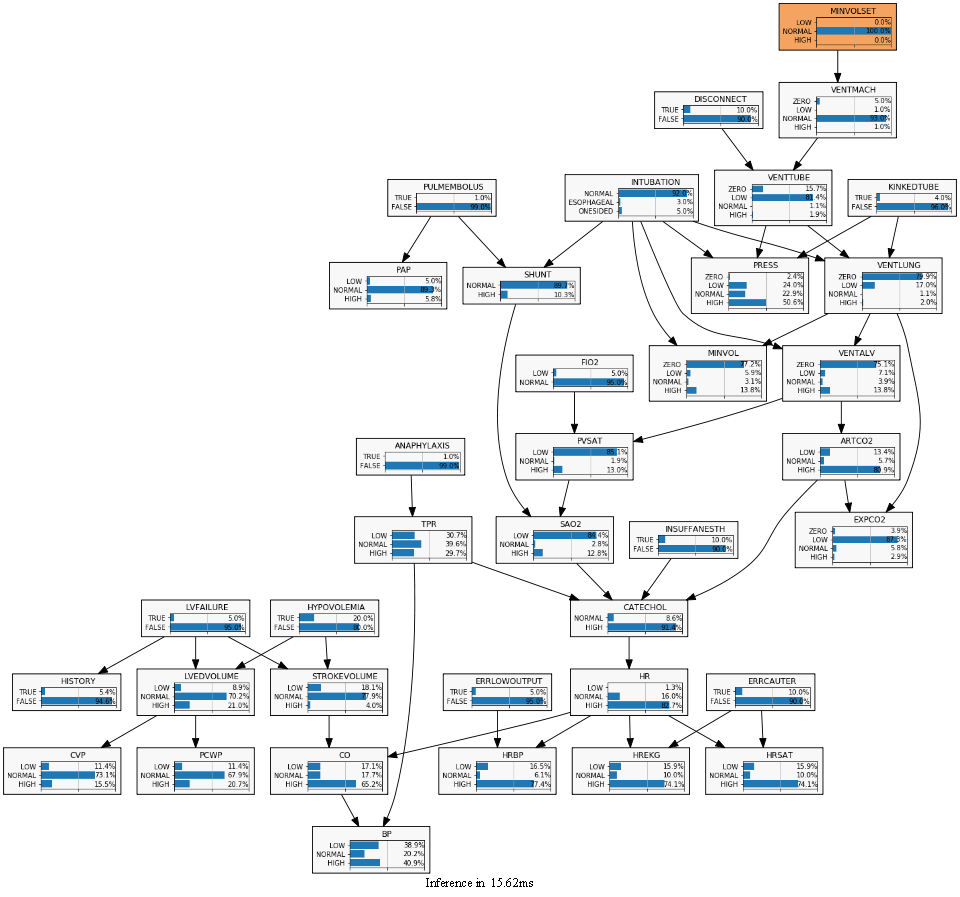

In [43]:
gnb.showInference(bn,size="10",evs={'MINVOLSET':'NORMAL'})

In [44]:
#ie=gum.LazyPropagation(bn)
ie.evidenceImpact('PRESS',['SHUNT','VENTALV'])

(gum::Potential<double>@0779A860) <PRESS:ZERO|VENTALV:ZERO|SHUNT:NORMAL> :: 0.0221183 /<PRESS:LOW|VENTALV:ZERO|SHUNT:NORMAL> :: 0.263196 /<PRESS:NORMAL|VENTALV:ZERO|SHUNT:NORMAL> :: 0.269519 /<PRESS:HIGH|VENTALV:ZERO|SHUNT:NORMAL> :: 0.445166 /<PRESS:ZERO|VENTALV:LOW|SHUNT:NORMAL> :: 0.125371 /<PRESS:LOW|VENTALV:LOW|SHUNT:NORMAL> :: 0.10827 /<PRESS:NORMAL|VENTALV:LOW|SHUNT:NORMAL> :: 0.110427 /<PRESS:HIGH|VENTALV:LOW|SHUNT:NORMAL> :: 0.655931 /<PRESS:ZERO|VENTALV:NORMAL|SHUNT:NORMAL> :: 0.0286313 /<PRESS:LOW|VENTALV:NORMAL|SHUNT:NORMAL> :: 0.267487 /<PRESS:NORMAL|VENTALV:NORMAL|SHUNT:NORMAL> :: 0.211507 /<PRESS:HIGH|VENTALV:NORMAL|SHUNT:NORMAL> :: 0.492375 /<PRESS:ZERO|VENTALV:HIGH|SHUNT:NORMAL> :: 0.011516 /<PRESS:LOW|VENTALV:HIGH|SHUNT:NORMAL> :: 0.276194 /<PRESS:NORMAL|VENTALV:HIGH|SHUNT:NORMAL> :: 0.0704238 /<PRESS:HIGH|VENTALV:HIGH|SHUNT:NORMAL> :: 0.641867 /<PRESS:ZERO|VENTALV:ZERO|SHUNT:HIGH> :: 0.0230181 /<PRESS:LOW|VENTALV:ZERO|SHUNT:HIGH> :: 0.260988 /<PRESS:NORMAL|VENTALV:ZERO|SHUNT:HIGH> :: 0.26437 /<PRESS:HIGH|VENTALV:ZERO|SHUNT:HIGH> :: 0.451623 /<PRESS:ZERO|VENTALV:LOW|SHUNT:HIGH> :: 0.0242729 /<PRESS:LOW|VENTALV:LOW|SHUNT:HIGH> :: 0.027722 /<PRESS:NORMAL|VENTALV:LOW|SHUNT:HIGH> :: 0.0211337 /<PRESS:HIGH|VENTALV:LOW|SHUNT:HIGH> :: 0.926871 /<PRESS:ZERO|VENTALV:NORMAL|SHUNT:HIGH> :: 0.118778 /<PRESS:LOW|VENTALV:NORMAL|SHUNT:HIGH> :: 0.353364 /<PRESS:NORMAL|VENTALV:NORMAL|SHUNT:HIGH> :: 0.0360745 /<PRESS:HIGH|VENTALV:NORMAL|SHUNT:HIGH> :: 0.491783 /<PRESS:ZERO|VENTALV:HIGH|SHUNT:HIGH> :: 0.0136186 /<PRESS:LOW|VENTALV:HIGH|SHUNT:HIGH> :: 0.271903 /<PRESS:NORMAL|VENTALV:HIGH|SHUNT:HIGH> :: 0.068295 /<PRESS:HIGH|VENTALV:HIGH|SHUNT:HIGH> :: 0.646183

#  Entropy of all nodes

In [45]:
gnb.showInformation(bn,{},size="20")

# Impact of evidence

In [46]:
gnb.showInformation(bn,{"CO":0},size="9")

# Exploring the junction tree

Lazy Propagation, like several other inference algorithms, uses a junction tree to propagate information.

In [43]:
jt=ie.junctionTree()
gnb.showJunctionTree(bn,size="10",format='svg')

# Inference as a function

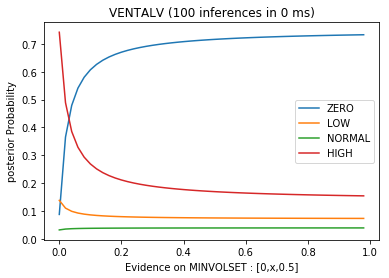

In [44]:
import time

r=range(0,100,2)
xs=[x/100.0 for x in r]

tf=time.time()
ys=[gum.getPosterior(bn,{'MINVOLSET':[0,x/100.0,0.5]},'VENTALV').tolist() 
        for x in r]
delta=time.time()-tf

p=plot(xs,ys)
legend(p,[bn.variableFromName('VENTALV').label(i) 
          for i in range(bn.variableFromName('VENTALV').domainSize())],loc=7);
title('VENTALV (100 inferences in %d ms)'%delta);
ylabel('posterior Probability');
xlabel('Evidence on MINVOLSET : [0,x,0.5]');

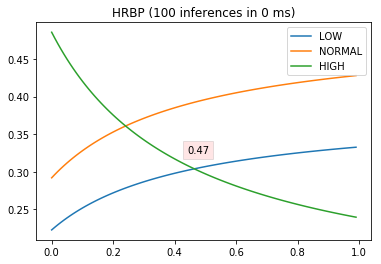

In [45]:
x=[p/100.0 for p in range(0,100)]

tf=time.time()
y=[gum.getPosterior(bn,{'HRBP':[1.0-p/100.0,1.0-p/100.0,p/100.0]},'TPR').tolist() 
   for p in range(0,100)]
delta=time.time()-tf

p=plot(x,y)
title('HRBP (100 inferences in %d ms)'%delta);
v=bn.variableFromName('TPR');
legend([v.label(i) for i in range(v.domainSize())],loc='best');
np1=(transpose(y)[2]>transpose(y)[0]).argmin()
text(x[np1]-0.03,y[np1][0]+0.02,str(x[np1]),bbox=dict(facecolor='red', alpha=0.1));

# Data generation

In [46]:
from pyAgrum.lib.bn2csv import generateCSV
generateCSV(bn,os.path.join("data","test.csv"),1000,visible=True)

** The library 'gum.lib.bn2csv' is deprecated in pyAgrum>0.12.0. Please use gum.generateCSV instead.
** The function 'gum.lib.bn2csv.generateCSV' is deprecated in pyAgrum>0.12.0. Please use gum.generateCSV instead.
** Class 'CSVGenerator' is is deprecated in pyAgrum>0.12.0. Please use gum.generateCSV instead.
 data/test.csv : [ ########################################################### ] 100%
Log2-Likelihood : -15077.155754415238



-15077.155754415238

In [47]:
from pyAgrum.lib._utils import oslike
#oslike.head(os.path.join('dossier', 'test.csv'))
oslike.head(os.path.join("data","test.csv"))

MINVOLSET,VENTMACH,DISCONNECT,VENTTUBE,INTUBATION,PULMEMBOLUS,SHUNT,PAP,FIO2,KINKEDTUBE,PRESS,VENTLUNG,VENTALV,PVSAT,SAO2,ARTCO2,EXPCO2,MINVOL,ANAPHYLAXIS,TPR,INSUFFANESTH,CATECHOL,HR,ERRCAUTER,HREKG,HRSAT,ERRLOWOUTPUT,HRBP,LVFAILURE,HISTORY,HYPOVOLEMIA,LVEDVOLUME,PCWP,CVP,STROKEVOLUME,CO,BP
NORMAL,NORMAL,FALSE,ZERO,NORMAL,FALSE,NORMAL,NORMAL,NORMAL,FALSE,HIGH,ZERO,ZERO,LOW,LOW,HIGH,LOW,ZERO,FALSE,HIGH,FALSE,HIGH,HIGH,FALSE,HIGH,HIGH,FALSE,HIGH,FALSE,FALSE,TRUE,HIGH,NORMAL,HIGH,NORMAL,HIGH,HIGH
NORMAL,NORMAL,FALSE,LOW,NORMAL,FALSE,NORMAL,NORMAL,NORMAL,FALSE,HIGH,ZERO,ZERO,LOW,LOW,LOW,ZERO,ZERO,FALSE,HIGH,FALSE,NORMAL,NORMAL,FALSE,LOW,LOW,FALSE,LOW,FALSE,FALSE,FALSE,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,HIGH
HIGH,HIGH,FALSE,HIGH,NORMAL,FALSE,NORMAL,LOW,NORMAL,FALSE,LOW,LOW,HIGH,HIGH,HIGH,LOW,LOW,HIGH,FALSE,NORMAL,FALSE,HIGH,HIGH,FALSE,HIGH,HIGH,FALSE,HIGH,FALSE,FALSE,TRUE,NORMAL,NORMAL,NORMAL,LOW,LOW,LOW
NORMAL,NORMAL,FALSE,LOW,NORMAL,FALSE,NORMAL,NORMAL,NORMAL,FALSE,HIGH,ZERO,ZERO,LOW,LOW

# BN as a probabistic classifier

 data/test.csv : [ ########################################################### ] 100%
 result in data/test.csv-ROC_alarm.bif-CATECHOL-HIGH.png


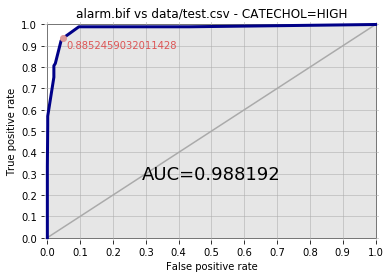

In [48]:
from pyAgrum.lib.bn2roc import showROC
showROC(bn,os.path.join("data","test.csv"),
        variable='CATECHOL',label='HIGH',  # class and label 
        visible=True,show_fig=True,with_labels=True)      

 data/test.csv : [ ########################################################### ] 100%
 result in data/test.csv-ROC_alarm.bif-SAO2-HIGH.png


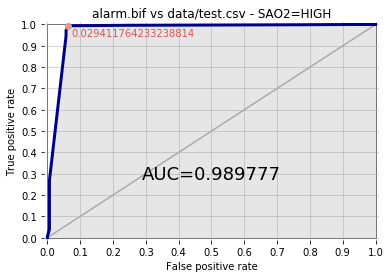

In [49]:
showROC(bn,os.path.join("data","test.csv"),'SAO2','HIGH',visible=True)

# Fast prototyping of BNs

In [50]:
bn1=gum.fastBN("a->b;a->c;b->c;c->d",3)
gnb.sideBySide(*[gnb.getInference(bn1,evs={'c':val},targets={'a','c','d'}) for val in range(3)],
              captions=["<pre>Inference given that c={}</pre>".format(val) for val in range(3)])

Inference given that c=0,Inference given that c=1,Inference given that c=2


In [51]:
print(gum.getPosterior(bn1,evs={'c':0},target='c'))
print(gum.getPosterior(bn1,evs={'c':0},target='a'))

<c:0> :: 1 /<c:1> :: 0 /<c:2> :: 0
<a:0> :: 0.55262 /<a:1> :: 0.0485037 /<a:2> :: 0.398876



# Joint posterior, impact of evidence

In [63]:
bn=gum.fastBN("a->b->c->d;b->e->d->f;g->c")
gnb.sideBySide(bn,gnb.getInference(bn))

In [64]:
ie=gum.LazyPropagation(bn)
ie.addJointTarget({"e","f","g"})
ie.makeInference()
gnb.sideBySide(ie.jointPosterior({"e","f","g"}),ie.jointPosterior({"e","f"}),
               captions=["Joint posterior $P(e,f,g)$","Joint posterior $P(e,f)$"])

In [65]:
gnb.sideBySide(ie.evidenceImpact("a",["e","f"]),ie.evidenceImpact("a",["d","e","f"]),
              captions=["$\\forall e,f, P(a|e,f)$",
                        "$\\forall d,e,f, P(a|d,e,f)=P(a|d,e)$ using d-separation"]
                        )

In [66]:
gnb.sideBySide(ie.evidenceJointImpact(["a","b"],["e","f"]),
               ie.evidenceJointImpact(["a","b"],["d","e","f"]),
              captions=["$\\forall e,f, P(a,b|e,f)$",
                        "$\\forall d,e,f, P(a,b|d,e,f)=P(a,b|d,e)$ using d-separation"]
                        )

# BN structure learning from data


In [67]:
!pwd
bn = gum.loadBN(os.path.join("templates","asia.bif"))
bn

'pwd' is not recognized as an internal or external command,
operable program or batch file.


(gum::BayesNet<double>@05E765E0) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [68]:
gum.generateCSV(bn,os.path.join("data","sample_asia.csv"),5000,True)
#gum.generateCSV(bn,"sample_asia.csv",5000,with_labels=True)

 data\sample_asia.csv : [ #################################################### ] 100%
Log2-Likelihood : -15927.97139804393


-15927.97139804393

In [69]:
import pandas
df=pandas.read_csv(os.path.join("data","sample_asia.csv"))
df.head()

,bronchitis?,tuberculos_or_cancer?,lung_cancer?,positive_XraY?,smoking?,visit_to_Asia?,tuberculosis?,dyspnoea?
0,0,1,1,1,0,1,1,0
1,0,1,1,1,1,1,1,0
2,0,1,1,1,0,1,1,0
3,1,1,1,1,0,1,1,1
4,0,1,1,1,1,1,1,0


In [70]:
#gum.generateCSV(bn,"sample_asia.csv",5000,with_labels=True)
c=pandas.crosstab(df['dyspnoea?'],[df['tuberculos_or_cancer?'],df['bronchitis?']])
c

tuberculos_or_cancer?    0         1      
bronchitis?              0   1     0     1
dyspnoea?                                 
0                      163  85  1666   242
1                       20  33   416  2375

In [71]:
import pyAgrum.lib._utils.oslike as oslike
print("===\n  Size of the generated database\n===")
oslike.wc_l(os.path.join("data","sample_asia.csv"))
print("\n===\n  First lines\n===")
oslike.head(os.path.join("data","sample_asia.csv"))

===
  Size of the generated database
===
5000

===
  First lines
===
bronchitis?,tuberculos_or_cancer?,lung_cancer?,positive_XraY?,smoking?,visit_to_Asia?,tuberculosis?,dyspnoea?
0,1,1,1,0,1,1,0
0,1,1,1,1,1,1,0
0,1,1,1,0,1,1,0
1,1,1,1,0,1,1,1
0,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1
1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,0,1,1,1



In [72]:
gum.generateCSV(bn,os.path.join("data","sample_asia.csv"),5000,with_labels=True)
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.names()

('visit_to_Asia?',
 'tuberculosis?',
 'tuberculos_or_cancer?',
 'positive_XraY?',
 'lung_cancer?',
 'smoking?',
 'bronchitis?',
 'dyspnoea?')

In [73]:
learner.setInitialDAG(bn.dag())
bn2=learner.learnParameters()
gnb.showBN(bn2)

In [74]:
learner.idFromName('lung_cancer?') 

4

In [75]:
learner.nameFromId(4)

'lung_cancer?'

In [76]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables and labels
learner.setInitialDAG(bn.dag())
bn2=learner.learnParameters()

In [77]:
from IPython.display import HTML

HTML('<table><tr><td style="text-align:center;"><h3>original BN</h3></td>'+
     '<td style="text-align:center;"><h3>Learned BN</h3></td></tr>'+
     '<tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('visit_to_Asia?')))
     +'</center></td></tr><tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis?')))
     +'</center></td></tr></table>')


# Various score-based learning algorithms


In [67]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,gnb.getInformation(bn2))
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

Learned in 11.654883ms


{'klPQ': 0.008512858799075993,
 'errorPQ': 0,
 'klQP': 0.005354778338162464,
 'errorQP': 128,
 'hellinger': 0.04812560152490729,
 'bhattacharya': 0.001158702155341796}

In [68]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,gnb.getInformation(bn2))

Learned in 4.999396ms


In [69]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useK2([0,1,2,3,4,5,6,7])
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Learned in 2.459505ms


(gum::BayesNet<double>@0x7f9b6d015a00) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [70]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useK2([7,6,5,4,3,2,1,0])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Learned in 0.002869523s


(gum::BayesNet<double>@0x7f9b6a030800) BN{nodes: 8, arcs: 12, domainSize: 256, parameters: 60, compression ratio: 76% }


# Plotting the score during learning

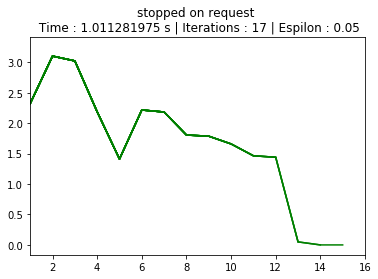

In [71]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 3 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()

# Learning a tree


In [72]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node

bntree=learner.learnBN()
bntree

(gum::BayesNet<double>@0x7f9b6b8be600) BN{nodes: 8, arcs: 6, domainSize: 256, parameters: 28, compression ratio: 89% }

# Learning with prior structural knowledge


In [73]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc("smoking?","lung_cancer?") # smoking->lung_cancer
# I know that visit to Asia may change the risk of tuberculosis
learner.addMandatoryArc("visit_to_Asia?","tuberculosis?") # visit_to_Asia->tuberculosis

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")

# Comparing BNs


In [74]:
help(gnb.getBNDiff)

Help on function getBNDiff in module pyAgrum.lib.notebook:

getBNDiff(bn1, bn2, size='4', format='png')
    get a HTML string representation of a graphical diff between the arcs of bn1 (reference) with those of bn2.
    
    * full black line: the arc is common for both
    * full red line: the arc is common but inverted in bn2
    * dotted black line: the arc is added in bn2
    * dotted red line: the arc is removed in bn2
    
    :param BayesNet bn1: referent model for the comparison
    :param BayesNet bn2: bn compared to the referent model
    :param size: size of the rendered graph
    :param format: render as "png" or "svg"



In [ ]:
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
              captions=['target','learned BN','graphical diffs between target and learned'])

In [ ]:
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

In [ ]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

In [ ]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

In [ ]:
learner=gum.BNLearner(os.path.join("data","sample_asia.csv"),bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
#learner.setMaxNbDecreasingChanges(2)

bn3=learner.learnBN()
kl=gum.BruteForceKL(bn,bn3)
gnb.sideBySide(bn3,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

In [ ]:
from pyAgrum.lib.bn2csv import generateCSV
generateCSV(bn,os.path.join("data","test.csv"),1000,visible=True)

In [ ]:
from pyAgrum.lib._utils import oslike
oslike.head(os.path.join("data","test.csv"))

In [ ]:
bn1=gum.fastBN("a->b;a->c;b->c;c->d",3)

gnb.sideBySide(*[gnb.getInference(bn1,evs={'c':val},
                targets={'a','c','d'}) for val in range(3)],
              captions=["<pre>Inference given that c={}</pre>".format(val) for val in range(3)])

---
# TO DO

- ### Implémenter avec PyAGrUM les exercices du partiel PGM. 
- ### Confirmer les résutats obtenus "à la main".
---

### Exercice HMM du partiel:
$$
P(S_1|S_1) = 0.8, \;
P(S_2|S_1) = 0.2,\;
P(S_2|S_2) = 0.6,\;
P(S_1|S_2) = 0.4
$$

transition probabilities for HMM:

$$
P(S_1|S_1) = 0.8, \;
P(S_2|S_1) = 0.2,\;
P(S_2|S_2) = 0.6,\;
P(S_1|S_2) = 0.4
$$

Emission probabilities:


$$
P(A|S_1) = 0.4, \;
P(C|S_1) = 0.1,\;
P(G|S_1) = 0.4,\;
P(T|S_1) = 0.1
$$
$$
P(A|S_2) = 0.2, \;
P(C|S_2) = 0.3,\;
P(G|S_2) = 0.2,\;
P(T|S_2) = 0.3
$$

an start probabilities as following:


$$
P(S_1) = 0.6, \;
P(S_2) = 0.4
$$

Assume the observed sequence is $x=GTAC$, calculate:

- $P(x)$ and compare with the forward algorithm.

- The posterior probability  $P(\pi_3=S_1|x)$ where $\pi_3$ is the state when the third symbol is emitted. 

- The most likely path of hidden states using by inference and compare with the path obtained with Viterbi algorithm.

In [4]:
hmm=gum.BayesNet('WaterSprinkler')
print(hmm)

BN{nodes: 0, arcs: 0, domainSize: 1, parameters: 0, compression ratio: 100-10^-inf% }


In [5]:
# 0 = S1; 1 = S2
x1=hmm.add(gum.LabelizedVariable('x1','s1 ?',2))
x2=hmm.add(gum.LabelizedVariable('x2','s1 ?',2))
x3=hmm.add(gum.LabelizedVariable('x3','s1 ?',2))
x4=hmm.add(gum.LabelizedVariable('x4','s1 ?',2))
print(x1, x2, x3, x4)

0 1 2 3


In [6]:
# 0 = A; 1 = C; 2 = G; 3 = T
y1=hmm.add(gum.LabelizedVariable('y1','G ?',4))
y2=hmm.add(gum.LabelizedVariable('y2','T ?',4))
y3=hmm.add(gum.LabelizedVariable('y3','A ?',4))
y4=hmm.add(gum.LabelizedVariable('y4','C ?',4))
print(y1, y2, y3, y4)

4 5 6 7


In [7]:
print(hmm)

BN{nodes: 8, arcs: 0, domainSize: 4096, parameters: 24, compression ratio: 99% }


In [8]:
for link in [(x1,x2),(x1,y1),(x2,x3),(x2,y2),(x3,x4),(x3,y3),(x4,y4)]:
    hmm.addArc(*link)
hmm

(gum::BayesNet<double>@06C52180) BN{nodes: 8, arcs: 7, domainSize: 4096, parameters: 46, compression ratio: 98% }

In [9]:
ps1ps2 = [0.6, 0.4]
hmm.cpt(x1).fillWith(ps1ps2)
hmm.cpt(x1)

(gum::Potential<double>@040E82D0) <x1:0> :: 0.6 /<x1:1> :: 0.4

In [10]:
hmm.cpt(x2)[:] = [[0.8, 0.2], [0.6, 0.4]]
hmm.cpt(x2)

(gum::Potential<double>@040E8360) <x2:0|x1:0> :: 0.8 /<x2:1|x1:0> :: 0.2 /<x2:0|x1:1> :: 0.6 /<x2:1|x1:1> :: 0.4

In [11]:
hmm.cpt(x3)[:] = [[0.8, 0.2], [0.6, 0.4]]
hmm.cpt(x4)[:] = [[0.8, 0.2], [0.6, 0.4]]

In [12]:
hmm.cpt(y1)[:] = [[0.4, 0.1, 0.4, 0.1], [0.2, 0.3, 0.2, 0.3]]
hmm.cpt(y1)

(gum::Potential<double>@040E88B8) <y1:0|x1:0> :: 0.4 /<y1:1|x1:0> :: 0.1 /<y1:2|x1:0> :: 0.4 /<y1:3|x1:0> :: 0.1 /<y1:0|x1:1> :: 0.2 /<y1:1|x1:1> :: 0.3 /<y1:2|x1:1> :: 0.2 /<y1:3|x1:1> :: 0.3

In [13]:
hmm.cpt(y2)[:] = [[0.4, 0.1, 0.4, 0.1], [0.2, 0.3, 0.2, 0.3]]
hmm.cpt(y3)[:] = [[0.4, 0.1, 0.4, 0.1], [0.2, 0.3, 0.2, 0.3]]
hmm.cpt(y4)[:] = [[0.4, 0.1, 0.4, 0.1], [0.2, 0.3, 0.2, 0.3]]
hmm.cpt(y2)

(gum::Potential<double>@040E8678) <y2:0|x2:0> :: 0.4 /<y2:1|x2:0> :: 0.1 /<y2:2|x2:0> :: 0.4 /<y2:3|x2:0> :: 0.1 /<y2:0|x2:1> :: 0.2 /<y2:1|x2:1> :: 0.3 /<y2:2|x2:1> :: 0.2 /<y2:3|x2:1> :: 0.3

In [14]:
pT = hmm.cpt(x1)*hmm.cpt(x2)*hmm.cpt(x3)*hmm.cpt(x4)*hmm.cpt(y1)*hmm.cpt(y2)*hmm.cpt(y3)*hmm.cpt(y4)

pGTAC = pT.margSumOut(['x1', 'x2', 'x3', 'x4'])
pGTAC

(gum::Potential<double>@040E8E88) <y4:0|y3:0|y2:0|y1:0> :: 0.01408 /<y4:1|y3:0|y2:0|y1:0> :: 0.00576 /<y4:2|y3:0|y2:0|y1:0> :: 0.01408 /<y4:3|y3:0|y2:0|y1:0> :: 0.00576 /<y4:0|y3:1|y2:0|y1:0> :: 0.005568 /<y4:1|y3:1|y2:0|y1:0> :: 0.002592 /<y4:2|y3:1|y2:0|y1:0> :: 0.005568 /<y4:3|y3:1|y2:0|y1:0> :: 0.002592 /<y4:0|y3:2|y2:0|y1:0> :: 0.01408 /<y4:1|y3:2|y2:0|y1:0> :: 0.00576 /<y4:2|y3:2|y2:0|y1:0> :: 0.01408 /<y4:3|y3:2|y2:0|y1:0> :: 0.00576 /<y4:0|y3:3|y2:0|y1:0> :: 0.005568 /<y4:1|y3:3|y2:0|y1:0> :: 0.002592 /<y4:2|y3:3|y2:0|y1:0> :: 0.005568 /<y4:3|y3:3|y2:0|y1:0> :: 0.002592 /<y4:0|y3:0|y2:1|y1:0> :: 0.00576 /<y4:1|y3:0|y2:1|y1:0> :: 0.0024 /<y4:2|y3:0|y2:1|y1:0> :: 0.00576 /<y4:3|y3:0|y2:1|y1:0> :: 0.0024 /<y4:0|y3:1|y2:1|y1:0> :: 0.002592 /<y4:1|y3:1|y2:1|y1:0> :: 0.001248 /<y4:2|y3:1|y2:1|y1:0> :: 0.002592 /<y4:3|y3:1|y2:1|y1:0> :: 0.001248 /<y4:0|y3:2|y2:1|y1:0> :: 0.00576 /<y4:1|y3:2|y2:1|y1:0> :: 0.0024 /<y4:2|y3:2|y2:1|y1:0> :: 0.00576 /<y4:3|y3:2|y2:1|y1:0> :: 0.0024 /<y4:0|y3:3|y2:1|y1:0> :: 0.002592 /<y4:1|y3:3|y2:1|y1:0> :: 0.001248 /<y4:2|y3:3|y2:1|y1:0> :: 0.002592 /<y4:3|y3:3|y2:1|y1:0> :: 0.001248 /<y4:0|y3:0|y2:2|y1:0> :: 0.01408 /<y4:1|y3:0|y2:2|y1:0> :: 0.00576 /<y4:2|y3:0|y2:2|y1:0> :: 0.01408 /<y4:3|y3:0|y2:2|y1:0> :: 0.00576 /<y4:0|y3:1|y2:2|y1:0> :: 0.005568 /<y4:1|y3:1|y2:2|y1:0> :: 0.002592 /<y4:2|y3:1|y2:2|y1:0> :: 0.005568 /<y4:3|y3:1|y2:2|y1:0> :: 0.002592 /<y4:0|y3:2|y2:2|y1:0> :: 0.01408 /<y4:1|y3:2|y2:2|y1:0> :: 0.00576 /<y4:2|y3:2|y2:2|y1:0> :: 0.01408 /<y4:3|y3:2|y2:2|y1:0> :: 0.00576 /<y4:0|y3:3|y2:2|y1:0> :: 0.005568 /<y4:1|y3:3|y2:2|y1:0> :: 0.002592 /<y4:2|y3:3|y2:2|y1:0> :: 0.005568 /<y4:3|y3:3|y2:2|y1:0> :: 0.002592 /<y4:0|y3:0|y2:3|y1:0> :: 0.00576 /<y4:1|y3:0|y2:3|y1:0> :: 0.0024 /<y4:2|y3:0|y2:3|y1:0> :: 0.00576 /<y4:3|y3:0|y2:3|y1:0> :: 0.0024 /<y4:0|y3:1|y2:3|y1:0> :: 0.002592 /<y4:1|y3:1|y2:3|y1:0> :: 0.001248 /<y4:2|y3:1|y2:3|y1:0> :: 0.002592 /<y4:3|y3:1|y2:3|y1:0> :: 0.001248 /<y4:0|y3:2|y2:3|y1:0> :: 0.00576 /<y4:1|y3:2|y2:3|y1:0> :: 0.0024 /<y4:2|y3:2|y2:3|y1:0> :: 0.00576 /<y4:3|y3:2|y2:3|y1:0> :: 0.0024 /<y4:0|y3:3|y2:3|y1:0> :: 0.002592 /<y4:1|y3:3|y2:3|y1:0> :: 0.001248 /<y4:2|y3:3|y2:3|y1:0> :: 0.002592 /<y4:3|y3:3|y2:3|y1:0> :: 0.001248 /<y4:0|y3:0|y2:0|y1:1> :: 0.007488 /<y4:1|y3:0|y2:0|y1:1> :: 0.003072 /<y4:2|y3:0|y2:0|y1:1> :: 0.007488 /<y4:3|y3:0|y2:0|y1:1> :: 0.003072 /<y4:0|y3:1|y2:0|y1:1> :: 0.003024 /<y4:1|y3:1|y2:0|y1:1> :: 0.001416 /<y4:2|y3:1|y2:0|y1:1> :: 0.003024 /<y4:3|y3:1|y2:0|y1:1> :: 0.001416 /<y4:0|y3:2|y2:0|y1:1> :: 0.007488 /<y4:1|y3:2|y2:0|y1:1> :: 0.003072 /<y4:2|y3:2|y2:0|y1:1> :: 0.007488 /<y4:3|y3:2|y2:0|y1:1> :: 0.003072 /<y4:0|y3:3|y2:0|y1:1> :: 0.003024 /<y4:1|y3:3|y2:0|y1:1> :: 0.001416 /<y4:2|y3:3|y2:0|y1:1> :: 0.003024 /<y4:3|y3:3|y2:0|y1:1> :: 0.001416 /<y4:0|y3:0|y2:1|y1:1> :: 0.003552 /<y4:1|y3:0|y2:1|y1:1> :: 0.001488 /<y4:2|y3:0|y2:1|y1:1> :: 0.003552 /<y4:3|y3:0|y2:1|y1:1> :: 0.001488 /<y4:0|y3:1|y2:1|y1:1> :: 0.001656 /<y4:1|y3:1|y2:1|y1:1> :: 0.000804 /<y4:2|y3:1|y2:1|y1:1> :: 0.001656 /<y4:3|y3:1|y2:1|y1:1> :: 0.000804 /<y4:0|y3:2|y2:1|y1:1> :: 0.003552 /<y4:1|y3:2|y2:1|y1:1> :: 0.001488 /<y4:2|y3:2|y2:1|y1:1> :: 0.003552 /<y4:3|y3:2|y2:1|y1:1> :: 0.001488 /<y4:0|y3:3|y2:1|y1:1> :: 0.001656 /<y4:1|y3:3|y2:1|y1:1> :: 0.000804 /<y4:2|y3:3|y2:1|y1:1> :: 0.001656 /<y4:3|y3:3|y2:1|y1:1> :: 0.000804 /<y4:0|y3:0|y2:2|y1:1> :: 0.007488 /<y4:1|y3:0|y2:2|y1:1> :: 0.003072 /<y4:2|y3:0|y2:2|y1:1> :: 0.007488 /<y4:3|y3:0|y2:2|y1:1> :: 0.003072 /<y4:0|y3:1|y2:2|y1:1> :: 0.003024 /<y4:1|y3:1|y2:2|y1:1> :: 0.001416 /<y4:2|y3:1|y2:2|y1:1> :: 0.003024 /<y4:3|y3:1|y2:2|y1:1> :: 0.001416 /<y4:0|y3:2|y2:2|y1:1> :: 0.007488 /<y4:1|y3:2|y2:2|y1:1> :: 0.003072 /<y4:2|y3:2|y2:2|y1:1> :: 0.007488 /<y4:3|y3:2|y2:2|y1:1> :: 0.003072 /<y4:0|y3:3|y2:2|y1:1> :: 0.003024 /<y4:1|y3:3|y2:2|y1:1> :: 0.001416 /<y4:2|y3:3|y2:2|y1:1> :: 0.003024 /<y4:3|y3:3|y2:2|y1:1> :: 0.001416 /<y4:0|y3:0|y2:3|y1:1> :: 0.003552 /<y4:1|y3:0|y2:3|y1:1> :: 0.001488 /<y4:2|y3:0|y2:3|

In [15]:
pGTAC[2,3,0,1]

0.0024000000000000007

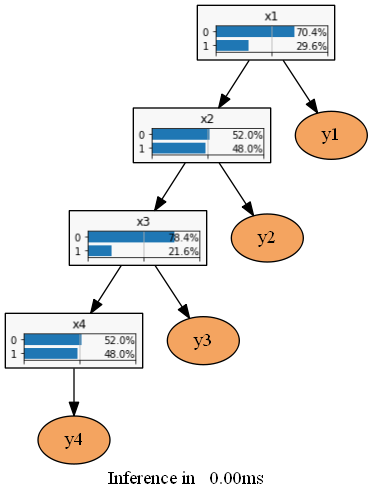

In [16]:
gnb.showInference(hmm,evs={'y1':2, 'y2': 3, 'y3': 0, 'y4': 1}, targets={'x1', 'x2', 'x3', 'x4'})

### Exercice BN du partiel:

Réseau bayésien sur (A,B,C,D,E):

\begin{align*}
     P(C=1\mid A=1,B=1) = 0.9 & & P(D=1\mid B=1) = 0.9 \\
     P(C=1\mid A=1,B=0) = 0.5 & & P(D=1\mid B=1) = 0.9 \\
     P(C=1\mid A=0,B=1) = 0.5 & & P(D=1\mid B=1) = 0.9 \\
     P(C=1\mid A=0,B=0) = 0.1 & & P(D=1\mid B=1) = 0.9 \\\\
     P(D=1\mid B=1) = 0.9 & & P(D=1\mid B=0) &= 0.1 \\
     P(E=1\mid C=1) = 0.9 & &P(E=1\mid C=0) &= 0.1 \\\\
     P(A=1) = 0.5 & & P(B=1) = 0.5
\end{align*}

- Montrer par inférence que $P(A=1,D=1\mid E=0) \neq P(A=1,D=1)$.
- Supposons que $C$ et $B$ ne soient pas observées. Créer un échantillon de données et apprendre une structure avec $A$, $D$ et $E$. Les indépendances entre $A$, $D$ et $E$ sont elles bien encodées dans ce nouveau DAG ? 

In [23]:
myBN=gum.fastBN("a->c;b->c;c->e;b->d")
myBN

(gum::BayesNet<double>@06C512F8) BN{nodes: 5, arcs: 4, domainSize: 32, parameters: 20, compression ratio: 37% }

In [24]:
myBN.cpt('a').fillWith([0.5, 0.5])

(gum::Potential<double>@06E3BF40) <a:0> :: 0.5 /<a:1> :: 0.5

In [25]:
myBN.cpt('b').fillWith([0.5, 0.5])

(gum::Potential<double>@06E3C180) <b:0> :: 0.5 /<b:1> :: 0.5

In [26]:
myBN.cpt('c')[1, 1, :] = [0.1, 0.9]
myBN.cpt('c')[1, 0, :] = [0.5, 0.5]
myBN.cpt('c')[0, 1, :] = [0.5, 0.5]
myBN.cpt('c')[0, 0, :] = [0.9, 0.1]
myBN.cpt('c')

(gum::Potential<double>@06E3BBB0) <c:0|a:0|b:0> :: 0.9 /<c:1|a:0|b:0> :: 0.1 /<c:0|a:1|b:0> :: 0.5 /<c:1|a:1|b:0> :: 0.5 /<c:0|a:0|b:1> :: 0.5 /<c:1|a:0|b:1> :: 0.5 /<c:0|a:1|b:1> :: 0.1 /<c:1|a:1|b:1> :: 0.9

In [27]:
myBN.cpt('e')[{'c': 1}] = [0.1, 0.9]
myBN.cpt('e')[{'c': 0}] = [0.9, 0.1]
myBN.cpt('e')

(gum::Potential<double>@06E3BC58) <e:0|c:0> :: 0.9 /<e:1|c:0> :: 0.1 /<e:0|c:1> :: 0.1 /<e:1|c:1> :: 0.9

In [28]:
myBN.cpt('d')[:] = [[0.9, 0.1], [0.1, 0.9]]
myBN.cpt('d')

(gum::Potential<double>@06E3BBC8) <d:0|b:0> :: 0.9 /<d:1|b:0> :: 0.1 /<d:0|b:1> :: 0.1 /<d:1|b:1> :: 0.9

In [29]:
pABCDE = myBN.cpt('a')*myBN.cpt('b')*myBN.cpt('c')*myBN.cpt('d')*myBN.cpt('e')
pABCDE

(gum::Potential<double>@06E358B0) <c:0|e:0|b:0|d:0|a:0> :: 0.18225 /<c:1|e:0|b:0|d:0|a:0> :: 0.00225 /<c:0|e:1|b:0|d:0|a:0> :: 0.02025 /<c:1|e:1|b:0|d:0|a:0> :: 0.02025 /<c:0|e:0|b:1|d:0|a:0> :: 0.01125 /<c:1|e:0|b:1|d:0|a:0> :: 0.00125 /<c:0|e:1|b:1|d:0|a:0> :: 0.00125 /<c:1|e:1|b:1|d:0|a:0> :: 0.01125 /<c:0|e:0|b:0|d:1|a:0> :: 0.02025 /<c:1|e:0|b:0|d:1|a:0> :: 0.00025 /<c:0|e:1|b:0|d:1|a:0> :: 0.00225 /<c:1|e:1|b:0|d:1|a:0> :: 0.00225 /<c:0|e:0|b:1|d:1|a:0> :: 0.10125 /<c:1|e:0|b:1|d:1|a:0> :: 0.01125 /<c:0|e:1|b:1|d:1|a:0> :: 0.01125 /<c:1|e:1|b:1|d:1|a:0> :: 0.10125 /<c:0|e:0|b:0|d:0|a:1> :: 0.10125 /<c:1|e:0|b:0|d:0|a:1> :: 0.01125 /<c:0|e:1|b:0|d:0|a:1> :: 0.01125 /<c:1|e:1|b:0|d:0|a:1> :: 0.10125 /<c:0|e:0|b:1|d:0|a:1> :: 0.00225 /<c:1|e:0|b:1|d:0|a:1> :: 0.00225 /<c:0|e:1|b:1|d:0|a:1> :: 0.00025 /<c:1|e:1|b:1|d:0|a:1> :: 0.02025 /<c:0|e:0|b:0|d:1|a:1> :: 0.01125 /<c:1|e:0|b:0|d:1|a:1> :: 0.00125 /<c:0|e:1|b:0|d:1|a:1> :: 0.00125 /<c:1|e:1|b:0|d:1|a:1> :: 0.01125 /<c:0|e:0|b:1|d:1|a:1> :: 0.02025 /<c:1|e:0|b:1|d:1|a:1> :: 0.02025 /<c:0|e:1|b:1|d:1|a:1> :: 0.00225 /<c:1|e:1|b:1|d:1|a:1> :: 0.18225

In [30]:
pADgivenE = (pABCDE.margSumOut(["b","c","e"])/pABCDE.margSumOut(["a","b","c","d"]))
pADgivenE

(gum::Potential<double>@06E359E8) <e:0|d:0|a:0> :: 0.5 /<e:1|d:0|a:0> :: 0.5 /<e:0|d:1|a:0> :: 0.5 /<e:1|d:1|a:0> :: 0.5 /<e:0|d:0|a:1> :: 0.5 /<e:1|d:0|a:1> :: 0.5 /<e:0|d:1|a:1> :: 0.5 /<e:1|d:1|a:1> :: 0.5

In [31]:
pAD = pABCDE.margSumOut(["b", "c", "e"])
pAD

(gum::Potential<double>@06E35B38) <d:0|a:0> :: 0.25 /<d:1|a:0> :: 0.25 /<d:0|a:1> :: 0.25 /<d:1|a:1> :: 0.25

In [144]:
gum.generateCSV(myBN,os.path.join("data","myBN.csv"),5000,True)

 data\myBN.csv : [ ########################################################### ] 100%
Log2-Likelihood : -18423.588164398738


-18423.588164398738

In [145]:
import pandas
myDF = pandas.read_csv(os.path.join("data","myBN.csv"))
myDF.head()

,a,c,b,e,d
0,1,0,0,1,0
1,0,0,0,0,0
2,1,1,1,1,1
3,1,1,0,1,0
4,0,0,0,0,0


In [146]:
myDF = myDF.drop(['b', 'c'], axis=1)
myDF.head()

,a,e,d
0,1,1,0
1,0,0,0
2,1,1,1
3,1,1,0
4,0,0,0


In [147]:
myDF.to_csv(os.path.join("data","myBNbis.csv"))

In [19]:
myBN2=gum.BayesNet('WaterSprinkler')
print(myBN2)

BN{nodes: 0, arcs: 0, domainSize: 1, parameters: 0, compression ratio: 100-10^-inf% }


In [20]:
a, d, e = [ myBN2.add(name, 2) for name in "ade" ]
myBN2

(gum::BayesNet<double>@06C4FBB8) BN{nodes: 3, arcs: 0, domainSize: 8, parameters: 6, compression ratio: 24% }

In [21]:
myLearner=gum.BNLearner(os.path.join("data","myBNbis.csv"),myBN2)

In [22]:
myLearner.useK2([0,1,2])
_bn2=myLearner.learnBN()
print("Learned in {0}ms".format(1000*myLearner.currentTime()))
gnb.sideBySide(_bn2,gnb.getInformation(_bn2))

Learned in 0.385622ms


G <!-- a --> a a <!-- e --> e e <!-- a->e --> a->e <!-- d --> d d <!-- d->e --> d->e


In [160]:
kl=gum.BruteForceKL(myBN2,_bn2)
kl.compute()

{'klPQ': 0.0,
 'errorPQ': 0,
 'klQP': 0.0,
 'errorQP': 8,
 'hellinger': 0.9999999999999999,
 'bhattacharya': inf}